In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

## Exercise 1

In [2]:
data = pd.DataFrame({
    'LSAT': [576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594],
    'GPA': [3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 2.96],
})

In [3]:
theta = data.corr().iloc[0, 1]
theta

np.float64(0.7763744912894074)

In [4]:
rng = np.random.default_rng(12345)

In [5]:
res = stats.bootstrap((data['LSAT'], data['GPA']), lambda x, y: stats.pearsonr(x, y)[0],
                      n_resamples=1000, vectorized=False, paired=True, random_state=rng)

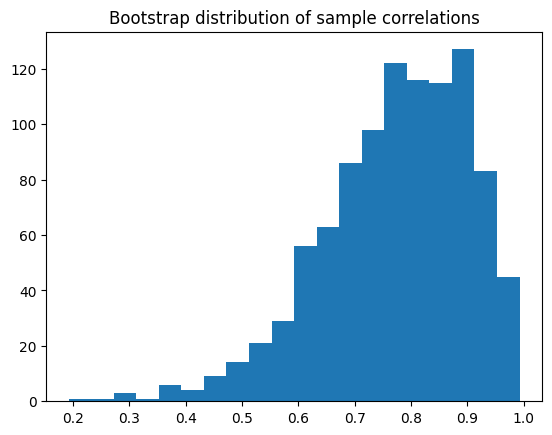

In [6]:
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=20);
ax.set_title('Bootstrap distribution of sample correlations');

The normal confidence interval:

In [7]:
alpha = 0.05

In [8]:
def normal_interval(theta, resample, alpha):
    se_boot = np.std(resample, ddof=1)
    return theta + stats.norm.ppf([alpha / 2, 1 - alpha / 2]) * se_boot

In [9]:
normal_interval(theta, res.bootstrap_distribution, alpha)

array([0.52098229, 1.03176669])

The basic confidence interval:

In [10]:
def basic_interval(theta, resample, alpha):
    return 2 * theta - np.quantile(resample, [1 - alpha / 2, alpha / 2])

In [11]:
basic_interval(theta, res.bootstrap_distribution, alpha)

array([0.58900992, 1.07819135])

The percentile confidence interval:

In [12]:
def percentile_interval(theta, resample, alpha):
    return np.quantile(resample, np.array([alpha / 2, 1 - alpha / 2]))

In [13]:
percentile_interval(theta, res.bootstrap_distribution, alpha)

array([0.47455763, 0.96373907])

## Exercise 2

Using the results of Exercise 10 in Chapter 3, we have $E[X_i] = e^{\frac12}$, $E[X_i^2] = e^2$ and $E[X_i^3] = e^{\frac92}$, so
$V[X_i] = E[X_i^2] - E[X_i]^2 = e^2 - e$, $\sigma_{X_i} = \sqrt{V[X_i]} = \sqrt{e^2 - e}$.

Now, $E\left[(X_i - E[X_i])^3\right] = E\left[X_i^3\right] - 3E\left[X_i^2\right] E[X_i] + 3E[X_i]^3 - E[X_i]^3 = e^{\frac92} - 3 e^{\frac52} + 2e^{\frac32} = e^{\frac32} \left(e^3 - 3 e + 2\right)$ and the skeweness is
$$\frac{E\left[(X_i - E[X_i])^3\right]}{\sigma^3} = \frac{e^3 - 3 e + 2}{(e - 1)^{\frac32}} = \frac{e^2 - e - 2}{\sqrt{e - 1}} = (e + 2) \sqrt{e - 1}.$$

First we check that the sample quantities converge to the theoretical values.

In [14]:
true_skewness = (np.e + 2) * np.sqrt(np.e - 1)
true_skewness

np.float64(6.184877138632554)

In [15]:
rng = np.random.default_rng(12345)

In [16]:
m = 1000
n = 50
y = stats.norm.rvs(size=(m, n), random_state=rng)
x = np.exp(y)

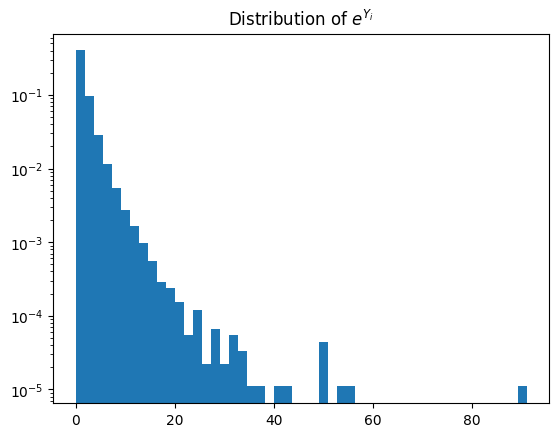

In [17]:
fig, ax = plt.subplots()
ax.hist(x.flatten(), bins=50, density=True);
ax.set_yscale('log');
ax.set_title('Distribution of $e^{Y_i}$');

In [18]:
means = np.mean(x, axis=1)
stds = np.std(x, axis=1, ddof=1)
skewnesses = stats.skew(x, axis=1)

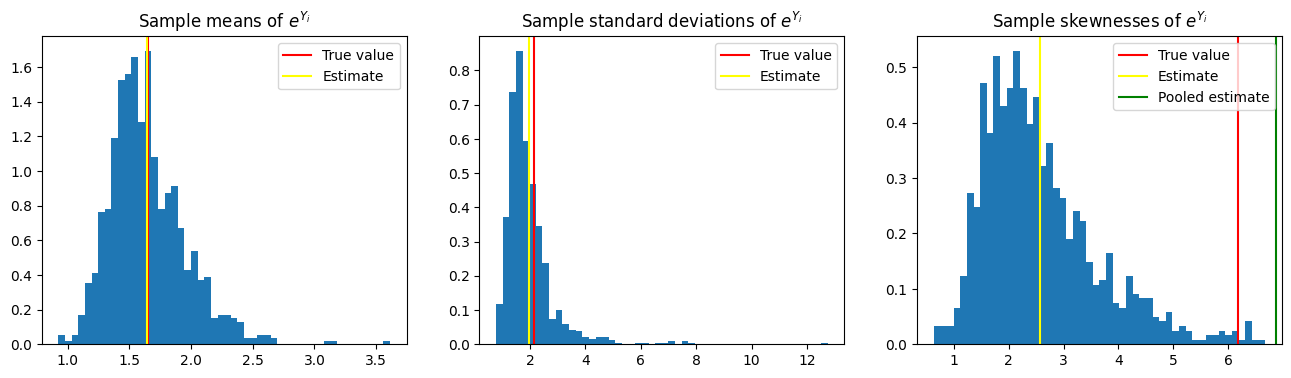

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].hist(means, bins=50, density=True);
axs[0].axvline(np.sqrt(np.e), color='red', label='True value');
axs[0].axvline(np.mean(means), color='yellow', label='Estimate')
axs[0].set_title('Sample means of $e^{Y_i}$');
axs[0].legend();

axs[1].hist(stds, bins=50, density=True);
axs[1].axvline(np.sqrt(np.e * (np.e - 1)), color='red', label='True value');
axs[1].axvline(np.mean(stds), color='yellow', label='Estimate')
axs[1].set_title('Sample standard deviations of $e^{Y_i}$');
axs[1].legend();

axs[2].hist(skewnesses, bins=50, density=True);
axs[2].axvline((np.e + 2) * np.sqrt(np.e - 1), color='red', label='True value');
axs[2].axvline(np.mean(skewnesses), color='yellow', label='Estimate')
axs[2].axvline(stats.skew(x.flatten()), color='green', label='Pooled estimate')
axs[2].set_title('Sample skewnesses of $e^{Y_i}$');
axs[2].legend();

We can size that for samples of size 50 the skewness does not converge well to the theoretical value.

Next we see how well bootstrap estimates the confidence interval.

In [20]:
s = rng.choice(x[0], size=(m, n))

In [21]:
means = np.mean(s, axis=1)
stds = np.std(s, axis=1, ddof=1)
skewnesses = stats.skew(s, axis=1)

In [22]:
def plot_estimate(ax, sample, theta, true_value, title, confint_func, alpha):
    confint = confint_func(theta, sample, alpha)

    ax.hist(sample, bins=50, density=True);
    ax.axvline(true_value, color='red', label='True value');
    ax.axvline(theta, color='yellow', label='Estimate');
    ax.axvline(confint[0], linestyle='--', color='darkgray');
    ax.axvline(confint[1], linestyle='--', color='darkgray');
    ax.set_title(title);
    ax.legend();

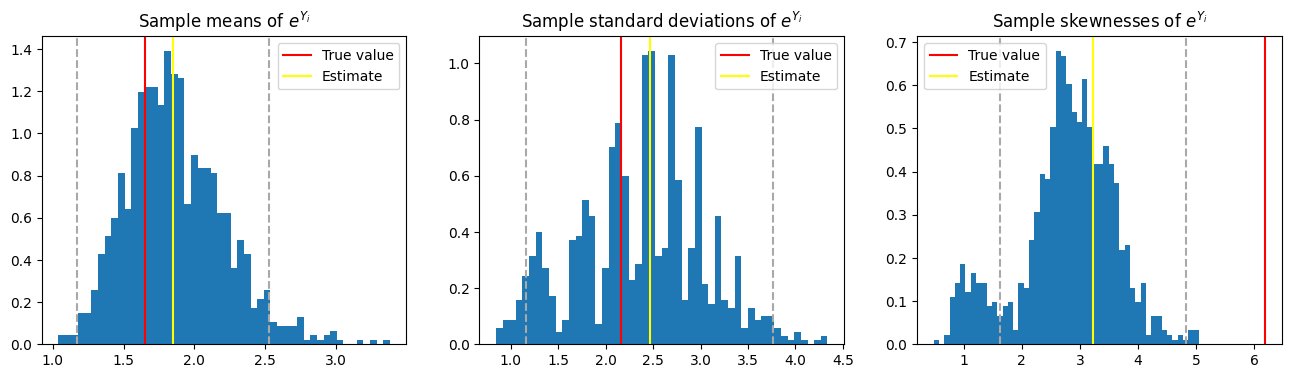

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plot_estimate(axs[0], means, np.mean(x[0]), np.sqrt(np.e), 'Sample means of $e^{Y_i}$', normal_interval, alpha)
plot_estimate(axs[1], stds, np.std(x[0], ddof=1), np.sqrt(np.e * (np.e - 1)), 'Sample standard deviations of $e^{Y_i}$', normal_interval, alpha)
plot_estimate(axs[2], skewnesses, stats.skew(x[0]), (np.e + 2) * np.sqrt(np.e - 1), 'Sample skewnesses of $e^{Y_i}$', normal_interval, alpha)

In [24]:
def test_coverage(sample, statistic, true_value, n_resamples, alpha, random_state):
    resample = stats.bootstrap((sample,), statistic, n_resamples=n_resamples, random_state=random_state).bootstrap_distribution
    def covers(interval_func):
        conf_int = interval_func(statistic(sample), resample, alpha)
        return conf_int[0] <= true_value <= conf_int[1]
    return covers(normal_interval), covers(basic_interval), covers(percentile_interval)

In [25]:
res = np.vstack([np.array(test_coverage(x[i], stats.skew, true_skewness, m, 0.05, rng)) for i in range(x.shape[0])])

In [26]:
np.mean(res, axis=0)

array([0.111, 0.145, 0.022])

We can see that the coverage is very low for all confidence intervals, hence 50 is an inadequate sample size for estimating skewness.

## Exercise 3

In [47]:
rng = np.random.default_rng(12345)

In [48]:
m = 1000
n = 25
x = stats.t.rvs(df=3, size=(m, n), random_state=rng)

In [49]:
def statistic(sample):
    qs = np.quantile(sample, [0.25, 0.75])
    return (qs[1] - qs[0]) / 1.34

In [51]:
true_value = (stats.t.ppf(0.75, df=3) - stats.t.ppf(0.25, df=3)) / 1.34
true_value

np.float64(1.1416303409020079)

In [52]:
res = np.vstack([np.array(test_coverage(x[i], statistic, true_value, m, 0.05, rng)) for i in range(x.shape[0])])
np.mean(res, axis=0)

array([0.954, 0.84 , 0.973])

In [32]:
np.argwhere(~res[:, 1]).reshape(1, -1)

array([[ 11,  12,  14,  16,  25,  30,  49,  55,  64,  77,  78,  81,  93,
         99, 112, 120, 121, 122, 129, 133, 136, 138, 141, 161, 162, 166,
        183, 202, 214, 215, 223, 241, 243, 246, 250, 258, 262, 270, 279,
        284, 292, 299, 303, 304, 306, 309, 319, 325, 328, 334, 367, 368,
        369, 374, 376, 381, 385, 397, 398, 401, 402, 407, 411, 415, 418,
        422, 426, 429, 430, 433, 440, 445, 446, 452, 461, 462, 466, 468,
        469, 478, 479, 500, 505, 506, 515, 522, 526, 533, 541, 544, 558,
        562, 563, 565, 574, 575, 586, 595, 603, 608, 611, 612, 613, 626,
        627, 634, 642, 645, 649, 667, 669, 675, 678, 683, 688, 691, 692,
        701, 703, 710, 711, 728, 738, 754, 767, 769, 780, 792, 801, 803,
        806, 807, 828, 829, 831, 838, 852, 873, 879, 881, 888, 889, 892,
        900, 901, 918, 920, 921, 927, 933, 937, 939, 940, 948, 952, 962,
        964, 974, 984, 985]])

In [33]:
def plot_result(ax, sample, alpha, title):
    resample = stats.bootstrap((sample,), statistic, n_resamples=m, random_state=rng).bootstrap_distribution
    plot_estimate(ax, resample, statistic(sample), true_value, title, basic_interval, alpha)

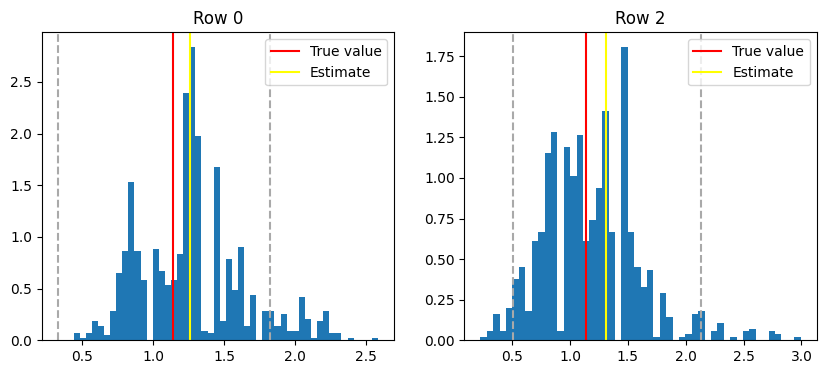

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_result(axs[0], x[0], 0.05, 'Row 0')
plot_result(axs[1], x[2], 0.05, 'Row 2')

We can see that the basic interval's true coverage is significantly lower than 95% for the sample size used.

## Exercise 4

The problem is equivalent to the question of how many ways there are to place $n$ balls into $n$ buckets, which in turn is equivalent to the problem of choosing positions of $n-1$ separators in a array of $n + n - 1 = 2n - 1$ slots (where the number of empty slots between separators represent the number of balls in the respective bucket). Therefore, there are $${2n - 1 \choose n}$$ distinct bootstrap samples.

## Exercise 5

Since each element in a bootstrap sample is picked with equal probability, we have
$$\mathbb{E}[X_i^* | X_1, \dots, X_n] = \frac{1}{n} \sum_{i=1}^n X_i$$
and
$$\mathbb{E}[(X_i^*)^2 | X_1, \dots, X_n] = \frac{1}{n} \sum_{i=1}^n X_i^2,$$
so
$$\mathbb{V}[X_i^* | X_1, \dots, X_n] 
= \mathbb{E}[(X_i^*)^2 | X_1, \dots, X_n] - \mathbb{E}[X_i^* | X_1, \dots, X_n]^2 
= \frac{1}{n} \sum_{i=1}^n X_i^2 - \left( \frac{1}{n} \sum_{i=1}^n X_i \right)^2.$$

Then
$$E\left[\bar{X}_n^* | X_1, \dots, X_n\right] 
= E\left[\left. \frac{1}{n} \sum_{i=1}^n X_i^* \right| X_1, \dots, X_n \right]
= \frac{1}{n} \sum_{i=1}^n E\left[X_i^* | X_1, \dots, X_n \right]
= \frac{1}{n} \sum_{i=1}^n X_i$$
and
$$\begin{split}
V\left[{\bar{X}_n^*} | X_1, \dots, X_n\right]
= V\left[\left. \frac{1}{n} \sum_{i=1}^n X_i^* \right| X_1, \dots, X_n\right]
= \frac{1}{n^2} \sum_{i=1}^n V\left[\left. X_i^* \right| X_1, \dots, X_n\right]
= \frac{1}{n} \left( \frac{1}{n} \sum_{i=1}^n X_i^2 - \left( \frac{1}{n} \sum_{i=1}^n X_i \right)^2 \right)
\end{split}$$

For the unconditional expectations:
$$E\left[\bar{X}_n^*\right] 
= E\left[E\left[\bar{X}_n^* | X_1, \dots, X_n\right]\right]
= E\left[\frac{1}{n} \sum_{i=1}^n X_i\right]
= E[X_i].$$

We have
$$\begin{split}
E\left[V\left[{\bar{X}_n^*} | X_1, \dots, X_n\right]\right]
&= E\left[ \frac{1}{n} \left( \frac{1}{n} \sum_{i=1}^n X_i^2 - \left( \frac{1}{n} \sum_{i=1}^n X_i \right)^2 \right) \right] \\
&= \frac{1}{n} \left( E[X_i^2] -  \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n E[X_i X_j] \right) \\
&= \frac{1}{n} \left( E[X_i^2] -  \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n \left( \text{Cov}(X_i, X_j) + E[X_i]E[X_j] \right) \right) \\
&= \frac{1}{n} \left( E[X_i^2] -  \frac{1}{n^2} \left( n V[X_i] + n^2 E[X_i]^2\right) \right) \\
&= \frac{1}{n} \left( E[X_i^2] - E[X_i]^2 + \frac{V[X_i]}{n} \right) \\
&= \frac{n - 1}{n^2} V[X_i]
\end{split}$$
and
$$\begin{split}
V\left[E\left[{\bar{X}_n^*} | X_1, \dots, X_n\right]\right]
&= \frac{1}{n} V[X_i],
\end{split}$$
so
$$V[{\bar{X}_n^*}] = E\left[V\left[{\bar{X}_n^*} | X_1, \dots, X_n\right]\right] + V\left[E\left[{\bar{X}_n^*} | X_1, \dots, X_n\right]\right]
= \frac{2n - 1}{n^2} V[X_i].$$

We can see that
$$V[{\bar{X}_n^*}] = \frac{2n-1}{n} \frac{V[X_i]}{n} = \frac{2n-1}{n} V[\bar{X}_n] \approx 2 V[\bar{X}_n]$$
when $n \to \infty$.

## Exercise 6

(a)

In [53]:
rng = np.random.default_rng(12345)

In [54]:
m = 1000
n = 100
x = stats.norm.rvs(loc=5, size=(n), random_state=rng)

In [55]:
theta = np.exp(np.mean(x))
theta

np.float64(144.28524623043373)

In [56]:
resample = stats.bootstrap((x,), lambda x: np.exp(np.mean(x)), n_resamples=m, random_state=rng).bootstrap_distribution

The standard error for $theta$:

In [57]:
se = np.std(resample, ddof=1)
se

np.float64(13.676532520997633)

The 95% normal confidence interval:

In [58]:
normal_interval(theta, resample, 0.05)

array([117.47973506, 171.0907574 ])

(b)

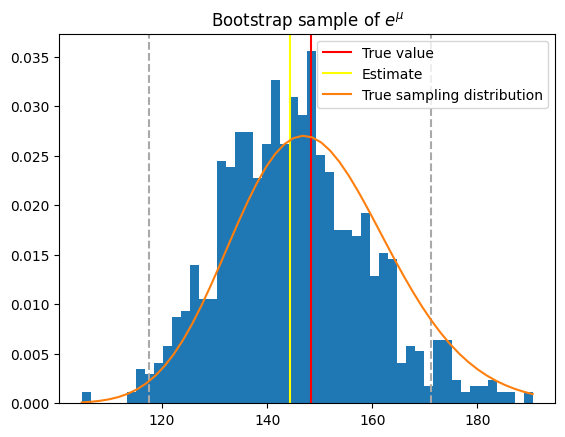

In [61]:
fig, ax = plt.subplots()
plot_estimate(ax, resample, theta, np.exp(5), 'Bootstrap sample of $e^\\mu$', normal_interval, 0.05)

grid = np.linspace(np.min(resample), np.max(resample))
ax.plot(grid, stats.lognorm.pdf(grid, s=1 / np.sqrt(n), scale=np.exp(5)), label='True sampling distribution');
ax.legend();

## Exercise 7

(a) Using the results of Exercise 3 in Chapter 3, we know that the pdf of $\hat{\theta}$ is
$$f_{\hat{\theta}}(x) = \begin{cases}
0, &\text{if } x < 0, \\
n x^{n-1}, &\text{if } 0 \leq x < 1, \\
0, &\text{if } 1 \leq x,
\end{cases}$$
and its expectation is $\frac{n}{n+1}$.

In [62]:
rng = np.random.default_rng(12345)

In [63]:
m = 1000
n = 50
x = stats.uniform.rvs(size=(n), random_state=rng)

In [64]:
theta = np.max(x)
theta

np.float64(0.9488811518333182)

In [65]:
resample = stats.bootstrap((x,), lambda x: np.max(x), n_resamples=m, random_state=rng).bootstrap_distribution

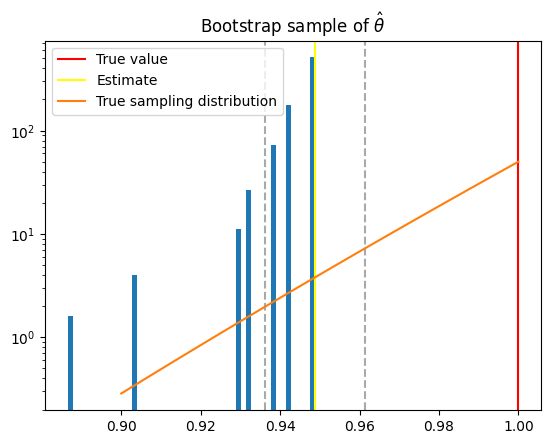

In [67]:
fig, ax = plt.subplots()
plot_estimate(ax, resample, theta, 1, 'Bootstrap sample of $\\hat{\\theta}$', normal_interval, 0.05)

grid = np.linspace(0.9, 1)
ax.plot(grid, n * grid ** (n - 1), label='True sampling distribution');
ax.set_yscale('log');
ax.legend();

(b) Bootstrap does poorly because the statistic selects an extreme value from the sample, so no resampling can improve the quality of this selection.

The probability that the statistic from a bootstrap resample is the same as the statistic from the sample is the probability of selecting the largest value in the sample at least once for a given resample, i.e.
$$P\left(\hat{\theta}^* = \hat{\theta}\right) = 1 - \left(1 - \frac{1}{n}\right)^n \xrightarrow[n \to \infty]{}1 - e^{-1} \approx 0.632.$$

On the other hand, $P(\hat{\theta} = \theta) = 0$, since $\hat{\theta}$ is a continuous random variable.